# Time Series Modeling: Spain Energy Data

## Prepare Notebook

**Read in libraries**

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings

**Set Notebook Preferences**

In [153]:
#Set Pandas preferenes
pd.options.display.max_rows = 100

#Set style for matplotlib
plt.style.use('ggplot')

#Surpress annoying warnings
warnings.filterwarnings('ignore')

**Read in data**

In [154]:
#Set path to data
path = r'\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\03_Processed_Data'

#Read in training and test data
X_train = pd.read_csv(path + '/2020_0624_Training_Data.csv', index_col=0)
X_test = pd.read_csv(path + '/2020_0624_Test_Data.csv', index_col=0)

#Read in price forecasts data
price_forecasts = pd.read_csv(path + '/2020_0620_Data_Price_Forecasts.csv', index_col=0)

**Preview Data**

In [155]:
print('Training data shape:', X_train.shape)
display(X_train.head())

print('\nTest data shape:',X_test.shape)
display(X_test.head())

print('\nPrice forecasts shape:',price_forecasts.shape)
display(price_forecasts.head())

Training data shape: (29809, 10)


,generation fossil gas,generation fossil gas differenced,generation fossil hard coal,generation fossil hard coal differenced,generation hydro pumped storage consumption,generation hydro pumped storage consumption differenced,price actual,price actual differenced,total load actual,total load actual differenced
date_time,,,,,,,,,,
2015-01-01 00:00:00,4844.0,-352.0,4821.0,66.0,863.0,-57.0,65.41,0.49,25385.0,1003.0
2015-01-01 01:00:00,5196.0,339.0,4755.0,174.0,920.0,-244.0,64.92,0.44,24382.0,1648.0
2015-01-01 02:00:00,4857.0,543.0,4581.0,450.0,1164.0,-339.0,64.48,5.16,22734.0,1448.0
2015-01-01 03:00:00,4314.0,184.0,4131.0,291.0,1503.0,-323.0,59.32,3.28,21286.0,1022.0
2015-01-01 04:00:00,4130.0,92.0,3840.0,250.0,1826.0,-283.0,56.04,2.41,20264.0,359.0



Test data shape: (5260, 5)


,generation fossil gas,generation fossil hard coal,generation hydro pumped storage consumption,price actual,total load actual
date_time,,,,,
2018-05-26 23:00:00,6678.0,4711.0,0.0,71.67,24953.0
2018-05-27 00:00:00,5891.0,4721.0,0.0,70.56,23327.0
2018-05-27 01:00:00,5287.0,4469.0,0.0,69.96,21861.0
2018-05-27 02:00:00,5130.0,4215.0,2.0,69.34,20801.0
2018-05-27 03:00:00,4991.0,4184.0,143.0,69.34,20358.0



Price forecasts shape: (35070, 1)


,price_forecast
date_time,
2015-01-01 00:00:00,50.10
2015-01-01 01:00:00,48.10
2015-01-01 02:00:00,47.33
2015-01-01 03:00:00,42.27
2015-01-01 04:00:00,38.41


# Modeling

### Evaluate original price forecast performance

**Prepare price_forecasts data**

In [156]:
cutoff = round(len(price_forecasts) *.85)


#Split forecasts to evaluate predictions on train/test data
price_train = price_forecasts.price_forecast[:cutoff]
price_test = price_forecasts[cutoff:]

#Check label shapes
print('Train label shape{} Test label shape: {}'.format(price_train.shape,price_test.shape))

Train label shape(29810,) Test label shape: (5260, 1)


**Evaluate fit and performance**

Original Price Model Performance Metrics
MAE:11.574648112593792
MAPE:0.16535110341777048
MSE:229.57666694840944
RMSE:15.15178758260587


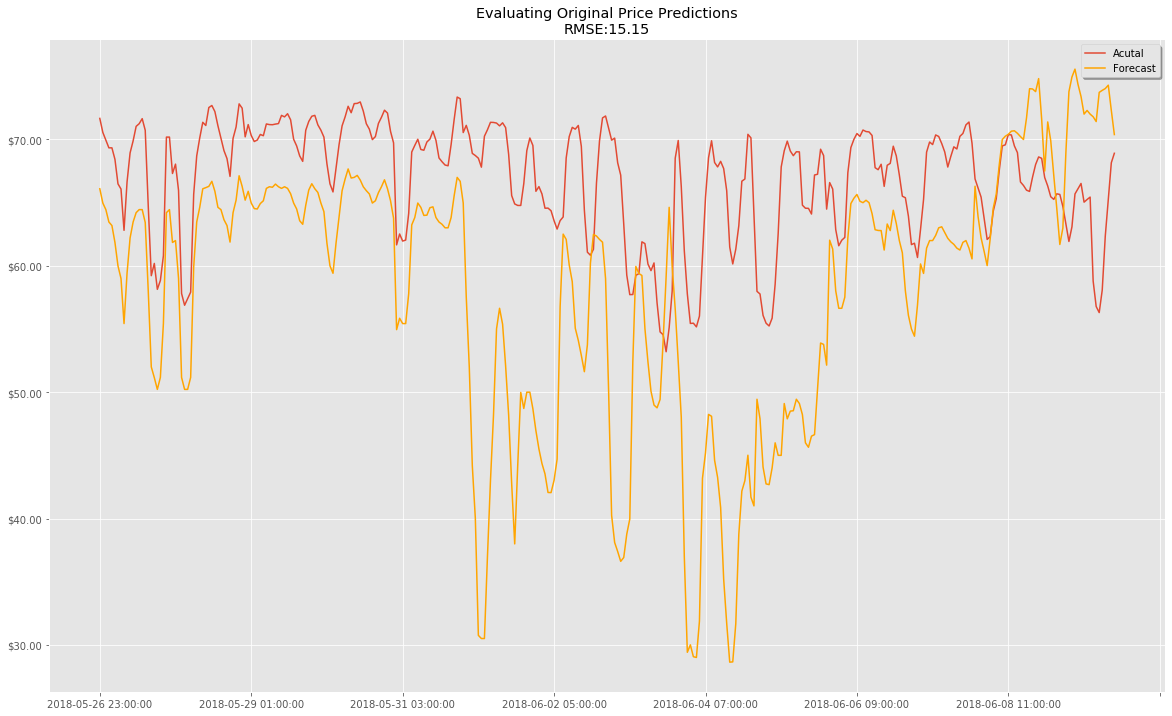

In [157]:
#Read in model_performance to capture metrics and timeseries_plot to plot timeseries
from TimeSeriesStats import model_performance
from TimeseriesPlotter import timeseries_plot

#Capture predictions
predictions = price_test.values
actual = X_test['price actual'].values

#Evaluate price preditions
metrics = model_performance(predictions, actual, 'Original Price Model')

#Create fig
f, ax = plt.subplots(figsize = (20,12))

#Plot original data
timeseries_plot(X_test['price actual'][:24*14], ax = ax)
timeseries_plot(price_test[:24*14],title='Evaluating Original Price Predictions\nRMSE:{}'.format(round(metrics['RMSE'],2)), color = 'orange', ax = ax, legend = True)

###Set plot aesthetics###
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax.legend(['Acutal', 'Forecast'], shadow = True);

## Univariate Analysis

**Prepare Data**

In [171]:
#Subset targets for training and test data for univariate models
train_univariate = X_train['price actual']
test_univariate = X_test['price actual']

#Check shape
print('Univarate training data shape:{}\nUnivariate test data shape:{}'.format(train_univariate.shape,test_univariate.shape))

Univarate training data shape:(29809,)
Univariate test data shape:(5260,)


### Base Model - Persistence Model Forecast

**Build Persistence Model Forecasts**

In [159]:
#Create list of historical values from price actual
history = [value for value in test_univariate.values]

#Init empty list to store predictions
predictions = []

#Predictions are the previous actual record
for i in range(len(test_univariate.values)):
    predictions.append(history[-1])
    history.append(test_univariate[i])

#Store predictions in a data frame for later plotting
persistence_model_predictions = pd.DataFrame(predictions,index=X_test.index)
persistence_model_predictions.columns = ['predictions']

#Check
display(persistence_model_predictions.head())

,predictions
date_time,
2018-05-26 23:00:00,69.88
2018-05-27 00:00:00,71.67
2018-05-27 01:00:00,70.56
2018-05-27 02:00:00,69.96
2018-05-27 03:00:00,69.34


**Evaluate Persistence Model**

Persistence Model Performance Metrics
MAE:1.9719771863117872
MAPE:0.029193151853497693
MSE:8.279855399239544
RMSE:2.8774737877588987


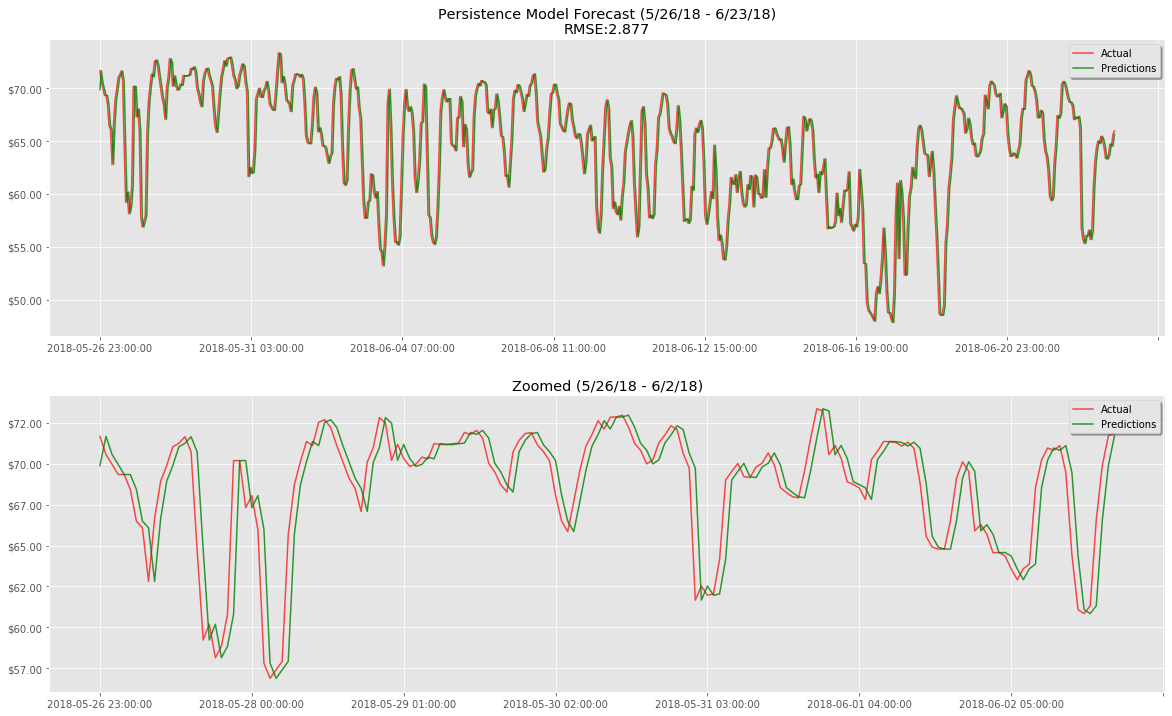

In [160]:
#Evaluate base model and store as metrics
metrics = model_performance(predictions,actual,'Persistence Model')

#Create fig
f, ax = plt.subplots(2,1,figsize = (20,12))

#Plot data 2 week zoom
timeseries_plot(X_test['price actual'][:24*28], ax=ax[0],color = 'red', alpha=.7)
timeseries_plot(persistence_model_predictions[:24*28], ax=ax[0], color = 'green',alpha=.8)

#Plot data 1 week zoom
timeseries_plot(X_test['price actual'][:24*7], ax=ax[1], color = 'red', alpha=.7)
timeseries_plot(persistence_model_predictions[:24*7], ax=ax[1], color = 'green', alpha=.8)

###Set plot aesthetics###
ax[0].set_title('Persistence Model Forecast (5/26/18 - 6/23/18)\nRMSE:{}'.format(round(metrics['RMSE'],3)))
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].legend(['Actual','Predictions'], frameon = True, shadow = True)

ax[1].set_title('Zoomed (5/26/18 - 6/2/18)')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[1].legend(['Actual','Predictions'], frameon = True, shadow = True)

Holt-Winters Exponential Smoothing

In [161]:
# #Import holt winters
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# #Init model
# holt_winters = ExponentialSmoothing(X_train['price actual'].values,seasonal='multi', seasonal_periods=24).fit(smoothing_level=0.8, smoothing_slope=0.2)

# #Make predictions
# holt_preds = holt_winters.forecast(len(test_univariate))

In [162]:
# #Store predictions and test values in a dataframe
# evaluate_hw = pd.DataFrame(holt_preds, index=test_univariate.index)
# evaluate_hw.columns = ['hw_preds']
# evaluate_hw['actual'] = test_univariate.values

# #Check
# display(evaluate_hw)

In [163]:
# hw_metrics = model_performance(evaluate_hw.hw_preds.values, evaluate_hw.actual.values, 'HW')

# f,ax = plt.subplots(2,1,figsize = (10,10))

# timeseries_plot(evaluate_hw.hw_preds, ax=ax[0])
# timeseries_plot(evaluate_hw.actual, ax=ax[0])

# timeseries_plot(evaluate_hw.hw_preds[:24*28], ax=ax[1])
# timeseries_plot(evaluate_hw.actual[:24*28], ax=ax[1])

**ARIMA Model**

In [176]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_univariate.values, order=(1,1,2))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                29808
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -77521.503
Method:                       css-mle   S.D. of innovations              3.260
Date:                Thu, 25 Jun 2020   AIC                         155053.006
Time:                        18:57:22   BIC                         155094.518
Sample:                             1   HQIC                        155066.329
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.393e-06      0.002      0.002      0.998      -0.004       0.004
ar.L1.D.y      0.8812      0.003    269.429      0.000       0.875       0.888
ma.L1.D.y     -0.5224      0.005   -112.424      0.000      -0.532      -0.513
ma.L2.D.y     -0.4650      0.004   -104.499      0.000      -0.474      -0.456
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1348           +0.0000j            1.1348            0.0000
MA.1            1.0087           +0.0000j            1.0087            0.0000
MA.2           -2.1323           +0.0000j            2.1323            0.5000
-----------------------------------------------------------------------------
"""

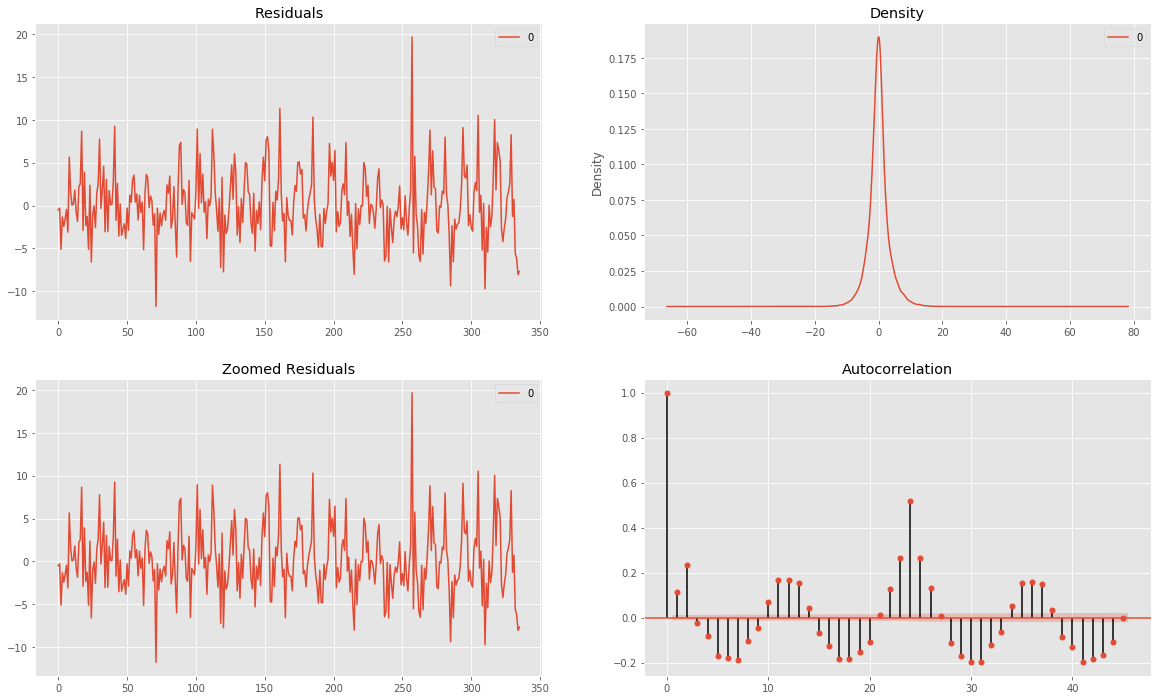

In [187]:
#Check residuals
from statsmodels.graphics.tsaplots import plot_acf


residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(2,2, figsize = (20,12))
residuals[:24*14].plot(title="Residuals", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[0,1])
residuals[:24*14].plot(title="Zoomed Residuals", ax=ax[1,0])
plot_acf(residuals, ax=ax[1,1])

plt.show()

ARIMA Performance Metrics
MAE:6.610422300729282
MAPE:0.09711666623088451
MSE:65.9738434490452
RMSE:8.122428420678462


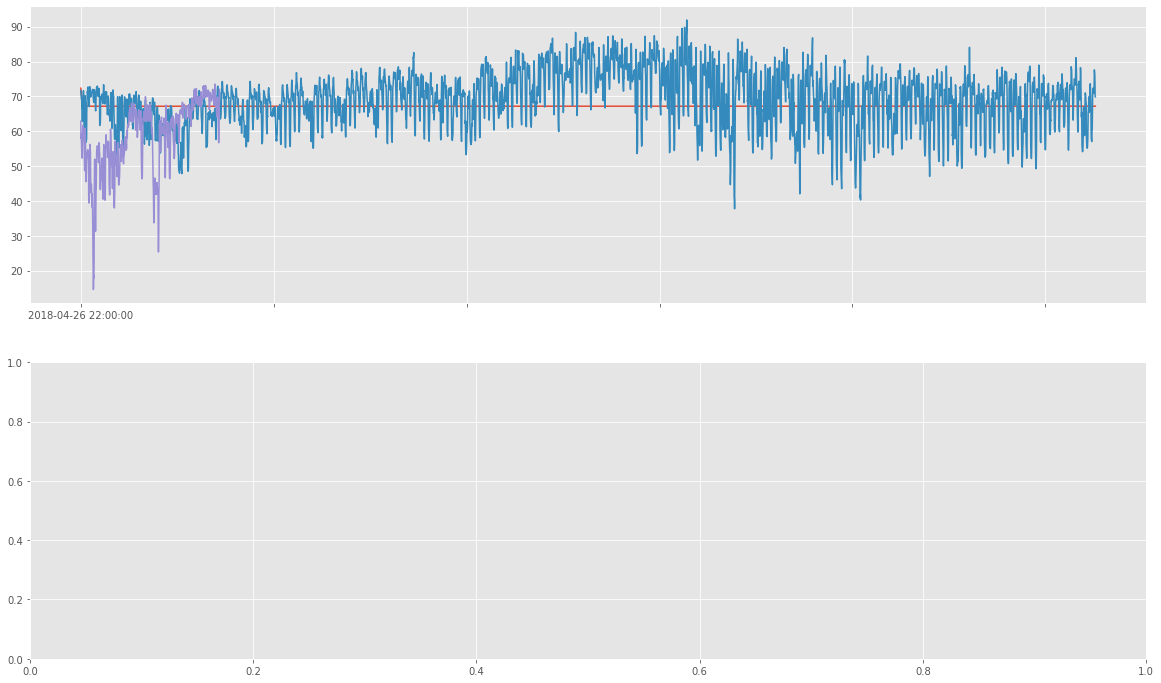

In [215]:
#Create forecast
fc,se,conf = model_fitted.forecast(len(test_univariate))

#Evaluate ARIMA's Performance
arima_metrics = model_performance(fc,test_univariate,'ARIMA')

#Store fc,conf in df for plotting
forecasts = pd.DataFrame(fc, index=test_univariate.index)
forecasts.columns = ['forecast']
forecasts['lower'] = conf[:,0]
forecasts['upper'] = conf[:,1]

#Set Figure
f, ax = plt.subplots(2,1,figsize = (20,12))

#Plot Data
timeseries_plot(forecasts['forecast'], ax = ax[0])
timeseries_plot(test_univariate, ax = ax[0])
timeseries_plot(train_univariate[-30*24:], ax = ax[0])


In [211]:
train_univariate[-30*24:]

date_time
2018-04-26 22:00:00    62.87
2018-04-26 23:00:00    57.98
2018-04-27 00:00:00    59.12
2018-04-27 01:00:00    57.13
2018-04-27 02:00:00    54.71
                       ...  
2018-05-26 17:00:00    56.71
2018-05-26 18:00:00    59.06
2018-05-26 19:00:00    66.41
2018-05-26 20:00:00    70.07
2018-05-26 21:00:00    72.03
Name: price actual, Length: 720, dtype: float64

In [205]:
forecasts

,0,lower,upper
date_time,,,
2018-05-26 23:00:00,72.342164,65.952670,78.731659
2018-05-27 00:00:00,71.728903,60.949094,82.508712
2018-05-27 01:00:00,71.188475,57.922691,84.454260
2018-05-27 02:00:00,70.712231,55.762090,85.662373
2018-05-27 03:00:00,70.292548,54.124692,86.460404
...,...,...,...
2018-12-31 19:00:00,67.201496,13.932963,120.470029
2018-12-31 20:00:00,67.201501,13.928648,120.474354
2018-12-31 21:00:00,67.201505,13.924333,120.478677


Build ARIMA Model

Tree MEthod(only after LSTM)

In [199]:
conf[:,0]

array([65.95267001, 60.94909385, 57.92269081, ..., 13.92433255,
       13.92001783, 13.91570346])

### Multivariate Analysis - Deep Learning

#### Prepare Data

In [ ]:
# #Get values as 1D arrays
# X = X_train['price actual'].values
# Y = X_test['price actual'].values

# #Normalize X and Y
# X_mean = np.mean(X)
# X_std = np.std(X)

# #Transfrom
# X = (X - X_mean)/X_std
# Y = (Y - X_mean)/X_std

In [ ]:
# #Define samples as 200 observations each from X
# samples = []
# length = 200

# #Iterate over X in groups of 200 and append to samples
# for i in range(0,len(X),length):
#     sample = X[i:i+length]
#     samples.append(sample)

# #Check
# print(len(samples))

In [ ]:
# samples = np.array(samples)
# len(samples)

In [ ]:
# lstm_model = tf.keras.models.Sequential()
# lstm_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape = X.shape))
# lstm_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# lstm_model.add(tf.keras.layers.Dense(10))

# #Compile
# lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [ ]:
# multi_step_history = lstm_model.fit(X, epochs=30,
#                                           steps_per_epoch=200,
#                                           validation_data=Y,
#                                           validation_steps=50)

**Select order of P for VAR Model

In [ ]:
# #Read in and init VARMAX
# from statsmodels.tsa.api import VAR

# model = VAR(X_train)


# # for p in list(range(1,10)):
# #     result = model.fit(p)
# #     print('Lag Order: ', p)
# #     print('Model Stats: \nAIC:{}\nBIC:{}\nFPE:{}\nHQIC:'.format(result.aic, result.bic, 
# #                                                                 result.fpe, result.hqic))
# #     print('============================================')

In [ ]:
# model.select_order(maxlags=24).summary()

In [ ]:
# model_fitted = model.fit(24, )


# #https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# #granger causility tes


**Check residuals**

In [ ]:
# #Import durbin_watson
# from statsmodels.stats.stattools import durbin_watson

# #Init durbin_watson and get serial correlation results
# serial_corr = durbin_watson(model_fitted.resid)

# #View results
# for col,value in zip(X_train.columns, serial_corr):
#     print(col, 'DW Statistic:', round(value,3))

**Forecast Predictions w/ VAR**

In [ ]:
# #Apply lag to X_train
# lag_order = model_fitted.k_ar
# var_input_data = X_train.values[-lag_order:]

In [ ]:
# forecast = model_fitted.forecast(var_input_data, steps = len(X_test))

In [ ]:
# #Create a dataframe of forecast values
# df_forecast = pd.DataFrame(forecast, index=X_test.index[-len(X_test):], columns=X_test.columns)

# df_forecast

**Plot Forecasts to see fit**

In [ ]:
# def invert_transformation(df_train, df_forecast, second_diff=False):
#     """Revert back the differencing to get the forecast to original scale."""
#     df_fc = df_forecast.copy()
#     columns = df_train.columns
#     for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
#         # Roll back 1st Diff
#         df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
#     return df_fc

In [ ]:
# predictions = pd.DataFrame()
# predictions['var_forecast'] = df_forecast['price actual']
# predictions['actual'] = X_test['price actual']
# #predictions['forecast_converted'] = predictions['var_forecast'].cumsum() + predictions['actual'].iloc[-1]
# predictions['forecast_converted'] = predictions['var_forecast'].cumsum() + predictions['actual'].iloc[-24]+ predictions['var_forecast'].iloc[-1]

# predictions.head(15)

In [ ]:
# f, ax = plt.subplots(figsize = (20,10))

# predictions['forecast_converted'][:24*90].plot(ax=ax, color = 'r')
# predictions['actual'][:24*90].plot(ax=ax, color = 'b')

# model_performance(predictions['forecast_converted'].values, predictions['actual'].values)

**Evaluate Metrics**

### Build LSTM model

**Prepare data**